### Mount my Google Drive

In [ ]:
import os
from google.colab import files, drive   

# mount the google drive to my Colab session
drive.mount('/content/gdrive')
print(os.listdir('/content/gdrive/My Drive/'))

### Install MXNet and GluonCV

In [ ]:
!pip install --upgrade mxnet-cu101 gluoncv

### Import necessary packages

In [3]:
import mxnet as mx
import numpy as np
import os, glob, shutil
import time, re

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs, TrainingHistory
from gluoncv.model_zoo import get_model

In [4]:
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

fs = 20
!wget https://github.com/trishume/OpenTuringCompiler/raw/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
fm.fontManager.ttflist += fm.createFontList(['Times New Roman.ttf'])
mpl.rc('font', family='Times New Roman', size=fs)

--2021-05-20 18:30:36--  https://github.com/trishume/OpenTuringCompiler/raw/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/trishume/OpenTuringCompiler/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf [following]
--2021-05-20 18:30:36--  https://raw.githubusercontent.com/trishume/OpenTuringCompiler/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘Times New Roman.ttf’

Times New Roman.ttf 100%[===================>] 814.89K  --.-KB/s    in 0.04s   



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  import sys


### Data preparation & Data augmentation

In [67]:
path = '/content/gdrive/My Drive/embryo-89-8cell-DIC_AIF_DTCWT-onset'
fluo_path = '/content/gdrive/My Drive/embryo-89-8cell-fluo-zmax-onset'

test_path = os.path.join(path, 'test')
fluo_test_path = os.path.join(fluo_path, 'test') # read in the fluorescence channel for comparison

In [68]:
npzfile = np.load(os.path.join(path, 'train_mean_std.npz'))
X_mean = npzfile['X_mean'].tolist()
X_std = npzfile['X_std'].tolist()
print(X_mean,X_std)

128.17645593242332 42.19776721563477


In [69]:
# z-score standardize the data
transform_test = transforms.Compose([
    transforms.Resize(600, keep_ratio=True),
    transforms.CenterCrop(512),

    transforms.ToTensor(),
    transforms.Normalize([X_mean], [X_std])
])

### Set hyperparameters 

In [70]:
classes = 2

per_device_batch_size = 16
num_gpus = 1
num_workers = 8
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
batch_size = per_device_batch_size * max(num_gpus, 1)

### Define data loader

In [71]:
test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

# read fluorescence channel of testing embryos for comparison
fluo_test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(fluo_test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

### Load saved models

In [73]:
model_name = 'ResNet50_v2'
ResNet_list = []
model_path = '/content/gdrive/My Drive/ResNet50_v2_weights_DIC_AIF_DTCWT/'
model_params = glob.glob(model_path+'*.params')

for k in range(len(model_params)):
  ResNet = get_model(model_name, pretrained=True)
  with ResNet.name_scope():
      ResNet.output = nn.Dense(classes)
  ResNet.output.initialize(init.Xavier(), ctx = ctx)
  ResNet.collect_params().reset_ctx(ctx)
  ResNet.hybridize()
  # Loading model parameters
  file_name = model_params[k]
  ResNet.load_parameters(file_name, ctx=ctx)
  ResNet_list.append(ResNet)

print('The number of DCNNs is %d.' % len(ResNet_list))

The number of DCNNs is 6.


### Evaluate on testing dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


The testing accuracy = 85.2%


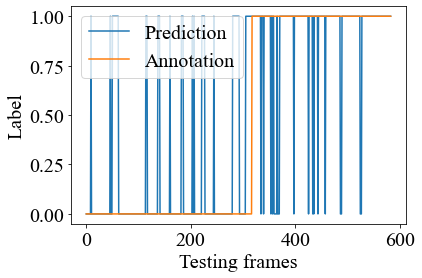

In [74]:
def get_ensemble_output(data, ResNet_list):
  output_sum = []
  for idx, ResNet in enumerate(ResNet_list):
    output = [ResNet(X) for X in data]
    if idx == 0:
      output_sum = output[0]
    else:
      output_sum = output_sum+output[0]
  output_sum = mx.ndarray.softmax(output_sum)
  return output_sum

record_pred_prob = [] # for 1 class
record_pred = []
record_label = []
for i, batch in enumerate(test_data):
  data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
  label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
  outputs = get_ensemble_output(data, ResNet_list)

  a = outputs.asnumpy()[:,1]
  b = np.argmax(outputs.asnumpy(),axis=1).astype('int32')
  c = label[0].asnumpy()
  if record_pred_prob == []:
    record_pred_prob = a
    record_pred = b
    record_label = c
  else:
    record_pred_prob = np.concatenate((record_pred_prob, a), axis=0)
    record_pred = np.concatenate((record_pred, b), axis=0)
    record_label = np.concatenate((record_label, c), axis=0)

plt.figure()
plt.plot(np.arange(len(record_pred)),record_pred,label='Prediction')
plt.plot(np.arange(len(record_label)),record_label,label='Annotation')
plt.legend()
plt.xlabel('Testing frames')
plt.ylabel('Label')

tp = np.equal(record_pred,record_label)
test_acc = np.sum(tp)/len(record_pred)
print('The testing accuracy = %.1f%%' % np.around(test_acc*100,1))

### Draw ROC curve

In [75]:
from sklearn.metrics import roc_curve, roc_auc_score

ns_prob = [0 for _ in range(len(record_label))] # no skill

# calculate scores
ns_auc = roc_auc_score(record_label, ns_prob)
lr_auc = roc_auc_score(record_label, record_pred_prob)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(record_label, ns_prob)
lr_fpr, lr_tpr, _ = roc_curve(record_label, record_pred_prob)

# bootstrap the testing dataset to get the empirical confidence interval of ROC curve and AUC score for DL model
y_true, y_pred = record_label, record_pred_prob

np.random.seed(13) # seed as early as possible
rng = np.random.RandomState(13)

n_bootstraps = 1000
lr_fprs, lr_tprs = [], []
bootstrapped_AUCs = []
for i in range(n_bootstraps):
  # bootstrap by sampling with replacement on the prediction indices
  indices = rng.randint(0, len(y_pred), len(y_pred))
  if len(np.unique(y_true[indices])) < 2:
      # We need at least one positive and one negative sample for ROC & AUC
      # to be defined: reject the sample
      continue
  fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
  auc_score = roc_auc_score(y_true[indices], y_pred[indices])
  lr_fprs.append(fpr)
  lr_tprs.append(tpr)
  bootstrapped_AUCs.append(auc_score)   

sorted_scores = np.array(bootstrapped_AUCs)
sorted_scores.sort()

CI = 0.95 # 95% confidence interval
confidence_lower = sorted_scores[int((1-CI)/2 * len(sorted_scores))]
confidence_upper = sorted_scores[int((1-(1-CI)/2) * len(sorted_scores))]
print("AUC of DL model: {:0.3f} ({:0.1f}% confidence interval, {:0.3f}-{:0.3})".format(lr_auc, CI*100, confidence_lower, confidence_upper))

AUC of DL model: 0.893 (95.0% confidence interval, 0.866-0.917)


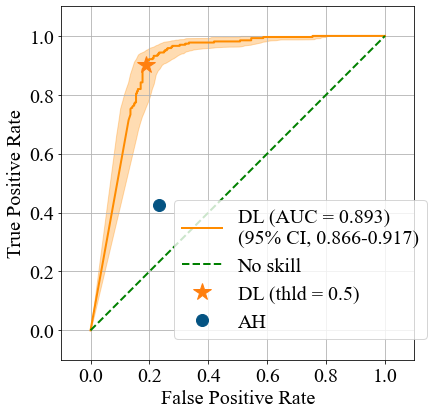

In [32]:
# DL(threshold=0.5) vs. AH
def my_ROC_point(Human_confusion):
  TN = Human_confusion[0]
  FP = Human_confusion[1]
  FN = Human_confusion[2]
  TP = Human_confusion[3]
  TPR = TP/(TP+FN)
  FPR = FP/(FP+TN)
  return TPR, FPR

confusion_matrices = np.array([[257,60,26,240],[243,74,153,113]]) # ['DL model', 'Average human']
ROC_points = []
for k in range(confusion_matrices.shape[0]):
  TPR, FPR = my_ROC_point(confusion_matrices[k,:])
  ROC_points.append([FPR,TPR])

x = np.linspace(0,1,150)
lr_tprs_interp = []
for fpr, tpr in zip(lr_fprs, lr_tprs):
  lr_tprs_interp.append(np.interp(x, fpr, tpr))
lr_tprs_interp_array = np.array(lr_tprs_interp)
ROC_curve_lower = np.percentile(lr_tprs_interp_array, 2.5, axis=0)
ROC_curve_upper = np.percentile(lr_tprs_interp_array, 97.5, axis=0)

# plot the ROC curve of DL with 95% CIs and the no skill curve
_, axes = plt.subplots(1, 1, figsize=(7, 6.5))
axes.grid()
axes.fill_between(x, ROC_curve_lower, ROC_curve_upper, alpha=0.3, color='darkorange')
axes.plot(lr_fpr, lr_tpr, color='darkorange', linewidth=2, label="DL (AUC = {:0.3f})\n({:0.0f}% CI, {:0.3f}-{:0.3})".format(lr_auc, CI*100, confidence_lower, confidence_upper))
axes.plot(ns_fpr, ns_tpr, color='g', linestyle='--', linewidth=2, label='No skill')

# plot the ROC point of DL and AH
marker_list = ['*','o']
cmap = mpl.cm.get_cmap('PuBu')
rgba = cmap((0.9))
color_list = ['C1',rgba]
label_list = ['DL (thld = 0.5)','AH']
size_list = [18,12]
for k, ROC_point in enumerate(ROC_points):
  axes.plot(ROC_point[0], ROC_point[1], marker_list[k], color=color_list[k], markersize=size_list[k], label=label_list[k])

axes.set_aspect('equal', adjustable='box')
axes.set_xlabel('False Positive Rate', fontsize=fs)
axes.set_ylabel('True Positive Rate', fontsize=fs)
axes.set_xlim([-0.1, 1.1])
axes.set_ylim([-0.1, 1.1])
axes.set_xticks((0,0.2,0.4,0.6,0.8,1.0))
axes.set_xticklabels(('0.0', '0.2', '0.4', '0.6', '0.8', '1.0'))
axes.legend(loc="upper left",bbox_to_anchor=(0.29,0.48))

plt.show()

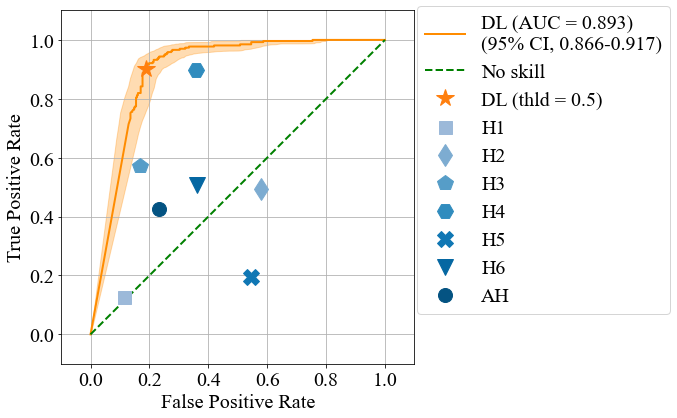

In [33]:
# DL(threshold=0.5) vs. six humans and AH
confusion_matrices = np.array([[257,60,26,240],[281,36,232,34],[133,184,135,131],[264,53,114,152],[203,114,27,239],[144,173,214,52],[202,115,131,135],[243,74,153,113]]) # [DL,H1-H6,AH]
ROC_points = []
for k in range(confusion_matrices.shape[0]):
  TPR, FPR = my_ROC_point(confusion_matrices[k,:])
  ROC_points.append([FPR,TPR])

x = np.linspace(0,1,150)
lr_tprs_interp = []
for fpr, tpr in zip(lr_fprs, lr_tprs):
  lr_tprs_interp.append(np.interp(x, fpr, tpr))
lr_tprs_interp_array = np.array(lr_tprs_interp)
ROC_curve_lower = np.percentile(lr_tprs_interp_array, 2.5, axis=0)
ROC_curve_upper = np.percentile(lr_tprs_interp_array, 97.5, axis=0)

# plot the ROC curve of DL with 95% CIs and the no skill curve
_, axes = plt.subplots(1, 1, figsize=(7, 6.5))
axes.grid()
axes.fill_between(x, ROC_curve_lower, ROC_curve_upper, alpha=0.3, color='darkorange')
axes.plot(lr_fpr, lr_tpr, color='darkorange', linewidth=2, label="DL (AUC = {:0.3f})\n({:0.0f}% CI, {:0.3f}-{:0.3})".format(lr_auc, CI*100, confidence_lower, confidence_upper))
axes.plot(ns_fpr, ns_tpr, color='g', linestyle='--', linewidth=2, label='No skill')

# plot the ROC point of DL(threshold=0.5), six humans and their average
marker_list = ['*','s','d','p','H','X','v','o']
cmap = mpl.cm.get_cmap('PuBu')
rgba = cmap(np.linspace(0.4,0.8,6))
color_list = ['C1',rgba[0],rgba[1],rgba[2],rgba[3],rgba[4],rgba[5],cmap(0.9)]
label_list = ['DL (thld = 0.5)','H1','H2','H3','H4','H5','H6','AH']
size_list = [18,13,16,16,16,16,16,14]
for k, ROC_point in enumerate(ROC_points):
  axes.plot(ROC_point[0], ROC_point[1], marker_list[k], color=color_list[k], markersize=size_list[k], label=label_list[k])

axes.set_aspect('equal', adjustable='box')
axes.set_xlabel('False Positive Rate', fontsize=fs)
axes.set_ylabel('True Positive Rate', fontsize=fs)
axes.set_xlim([-0.1, 1.1])
axes.set_ylim([-0.1, 1.1])
axes.set_xticks((0,0.2,0.4,0.6,0.8,1.0))
axes.set_xticklabels(('0.0', '0.2', '0.4', '0.6', '0.8', '1.0'))
axes.set_yticks((0,0.2,0.4,0.6,0.8,1.0))
axes.set_yticklabels(('0.0', '0.2', '0.4', '0.6', '0.8', '1.0'))
axes.legend(loc="upper left",bbox_to_anchor=(0.98,1.04),fontsize=fs)

plt.show()

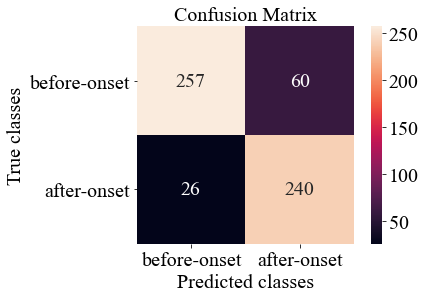

In [47]:
# confusion matrix of DL(threshold=0.5) 
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['before-onset','after-onset']
cm = confusion_matrix(record_label, record_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt="d", ax=ax) # annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted classes')
ax.set_ylabel('True classes')
ax.set_title('Confusion Matrix', fontsize=fs)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation='horizontal')
ax.set_aspect('equal', 'box')

### Time prediction analysis

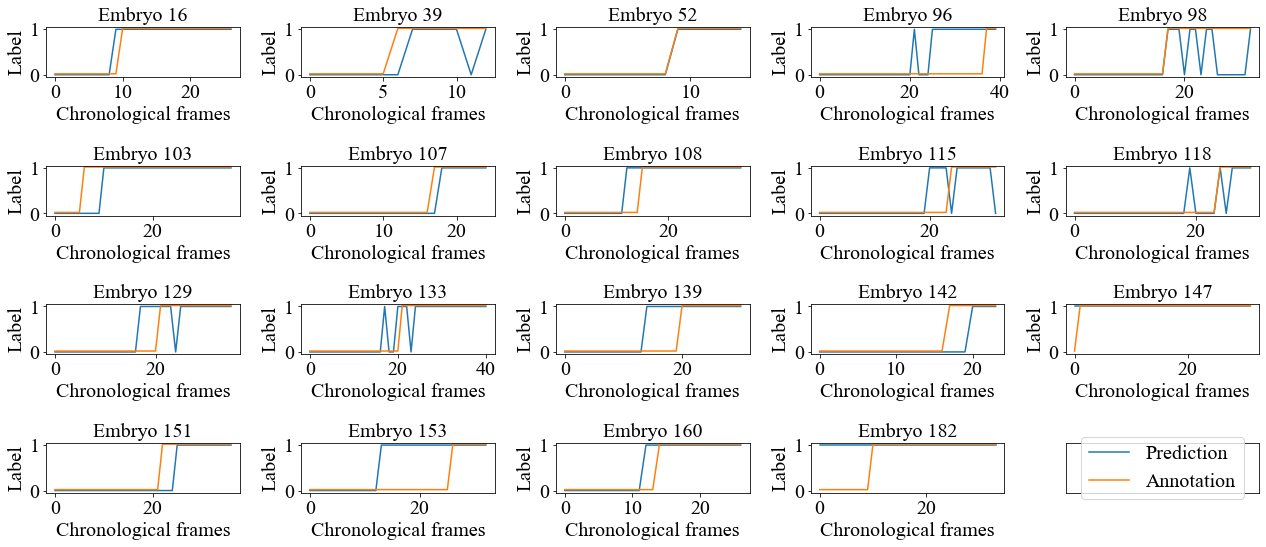

In [48]:
import pandas as pd

test_xlsx_path = path+'/embryo_info.xlsx'
dfs = pd.read_excel(test_xlsx_path)
usable_col = dfs.iloc[:,[0,1,2]].to_numpy()
split_idx = 70

test_embryo_idx = usable_col[split_idx:,0]
no_num = usable_col[split_idx:,1]
yes_num = usable_col[split_idx:,2]

reshape_record_label = np.split(record_label, np.cumsum(np.append(no_num, yes_num)))
del reshape_record_label[-1]
new_label_list = []
for k in range(int(len(reshape_record_label)/2)):
  new_label_list.append(np.append(reshape_record_label[k],reshape_record_label[k+int(len(reshape_record_label)/2)]))

reshape_record_pred = np.split(record_pred, np.cumsum(np.append(no_num, yes_num)))
del reshape_record_pred[-1]
new_pred_list = []
for k in range(int(len(reshape_record_pred)/2)):
  new_pred_list.append(np.append(reshape_record_pred[k],reshape_record_pred[k+int(len(reshape_record_label)/2)]))

img_row = 4
img_col = int(np.ceil(len(new_label_list)/img_row))
fig, axes = plt.subplots(img_row, img_col, figsize=(18, 8))
for k in range(len(new_label_list)):
  axes[int(k/img_col), k%img_col].plot(np.arange(len(new_pred_list[k])),new_pred_list[k],label='Prediction')
  axes[int(k/img_col), k%img_col].plot(np.arange(len(new_label_list[k])),new_label_list[k]+0.02,label='Annotation')
  axes[int(k/img_col), k%img_col].set_xlabel('Chronological frames')
  axes[int(k/img_col), k%img_col].set_ylabel('Label')
  axes[int(k/img_col), k%img_col].set_ylim((-0.05,1.05))
  axes[int(np.floor(k/img_col)), k%img_col].set_title('Embryo '+str(test_embryo_idx[k]),fontsize=fs)
axes[int(np.floor(k/img_col)), 19%img_col].plot(0,0,label='Prediction')
axes[int(np.floor(k/img_col)), 19%img_col].plot(1,1,label='Annotation')
axes[int(np.floor(k/img_col)), 19%img_col].legend(loc='center')
axes[int(np.floor(k/img_col)), 19%img_col].xaxis.set_visible(False)
axes[int(np.floor(k/img_col)), 19%img_col].yaxis.set_visible(False)

plt.tight_layout()

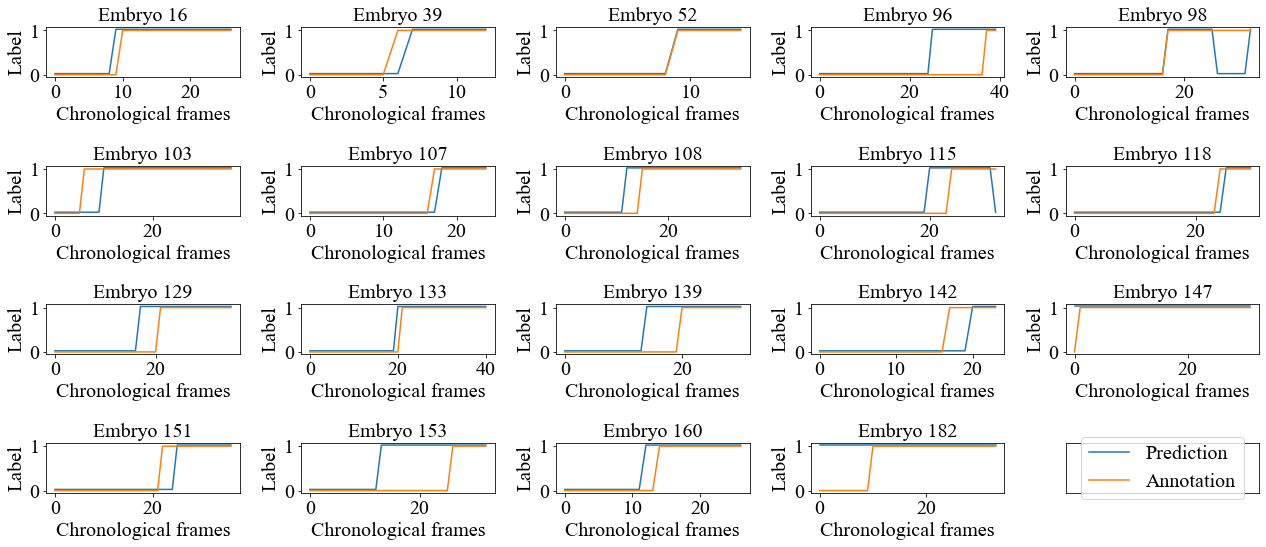

In [54]:
def slide_smooth(array_1D):
  temp = np.insert(array_1D, 0, array_1D[0], axis=0)
  array_1D_long = np.append(temp, [array_1D[-1]], axis=0)
  array_1D_before = array_1D_long[:-2]
  array_1D_after = array_1D_long[2:]
  array_1D_stack = np.vstack((array_1D_before, array_1D, array_1D_after))
  axis = 0
  u, indices = np.unique(array_1D_stack, return_inverse=True)
  majority_votes = u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(array_1D_stack.shape), None, np.max(indices) + 1), axis=axis)]
  if np.sum(majority_votes)==0:
    majority_votes = array_1D
  return majority_votes

smooth_pred_list = []
for k in range(len(new_pred_list)):
  smooth_pred_list.append(slide_smooth(new_pred_list[k]))
# vis
img_row = 4
img_col = int(np.ceil(len(new_label_list)/img_row))
fig, axes = plt.subplots(img_row, img_col, figsize=(18, 8))
for k in range(len(new_label_list)):
  axes[int(np.floor(k/img_col)), k%img_col].plot(np.arange(len(smooth_pred_list[k])),smooth_pred_list[k]+0.025,label='Prediction')
  axes[int(np.floor(k/img_col)), k%img_col].plot(np.arange(len(new_label_list[k])),new_label_list[k],label='Annotation')
  axes[int(np.floor(k/img_col)), k%img_col].set_xlabel('Chronological frames')
  axes[int(np.floor(k/img_col)), k%img_col].set_ylabel('Label')
  axes[int(np.floor(k/img_col)), k%img_col].set_title('Embryo '+str(test_embryo_idx[k]),fontsize=fs)
axes[int(np.floor(k/img_col)), 19%img_col].plot(0,0,label='Prediction')
axes[int(np.floor(k/img_col)), 19%img_col].plot(1,1,label='Annotation')
axes[int(np.floor(k/img_col)), 19%img_col].legend(loc='center')
axes[int(np.floor(k/img_col)), 19%img_col].xaxis.set_visible(False)
axes[int(np.floor(k/img_col)), 19%img_col].yaxis.set_visible(False)

plt.tight_layout()

In [55]:
first_pol = []
for embryo_pred in smooth_pred_list:
  itemindex = np.where(embryo_pred==1)
  if len(itemindex[0])>=1:
    first_pol.append(itemindex[0][0])
  else:
    first_pol.append(10000) # indicating a future time point

test_pol_time = []
for embryo_pred in new_label_list:
  itemindex = np.where(embryo_pred==1)
  if len(itemindex[0])>=1:
    test_pol_time.append(itemindex[0][0])
  else:
    test_pol_time.append(10000) # indicating a future time point
    
df = pd.DataFrame(np.transpose(np.array([test_embryo_idx, np.asarray(first_pol), test_pol_time])),
          columns=['testing embryo index', 'predicted pol. time', 'annotated pol. time'])
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('expand_frame_repr', False)
print(df)

    testing embryo index  predicted pol. time  annotated pol. time
0                     16                    9                   10
1                     39                    7                    6
2                     52                    9                    9
3                     96                   25                   37
4                     98                   17                   17
5                    103                   10                    6
6                    107                   18                   17
7                    108                   12                   15
8                    115                   20                   24
9                    118                   25                   24
10                   129                   17                   21
11                   133                   20                   21
12                   139                   14                   20
13                   142                   20                 

### Failure case analysis

In [56]:
tp = record_pred==record_label
itemindex = np.where(tp==False)

In [60]:
test_embryo_index = []
test_embryo_t_index = []
for k in range(len(no_num)):
  test_embryo_index.append(np.repeat(test_embryo_idx[k],no_num[k]))
  test_embryo_t_index.append(np.arange(no_num[k]))
for k in range(len(yes_num)):
  test_embryo_index.append(np.repeat(test_embryo_idx[k],yes_num[k]))
  test_embryo_t_index.append(np.arange(yes_num[k])+no_num[k])

test_embryo_index_flat = np.asarray([item for sublist in test_embryo_index for item in sublist])
test_embryo_t_index_flat = np.asarray([item for sublist in test_embryo_t_index for item in sublist])

df2 = pd.DataFrame(np.transpose(np.array([itemindex[0], test_embryo_index_flat[itemindex[0]], test_embryo_t_index_flat[itemindex[0]]])),
          columns=['testing frame index', 'testing embryo index', 'embryo t index'])
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df2)

    testing frame index  testing embryo index  embryo t index
0                     9                    16               9
1                    46                    96              21
2                    50                    96              25
3                    51                    96              26
4                    52                    96              27
5                    53                    96              28
6                    54                    96              29
7                    55                    96              30
8                    56                    96              31
9                    57                    96              32
10                   58                    96              33
11                   59                    96              34
12                   60                    96              35
13                   61                    96              36
14                  114                   108              12
15      

In [62]:
# look at the prediction confidence
FN_idx = 1
instance_idx = itemindex[0][FN_idx]
group_id = np.floor(instance_idx/batch_size)
for i, batch in enumerate(test_data):
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break

test_idx = np.remainder(instance_idx, batch_size)
test_image = data[0][test_idx].expand_dims(0)
test_label = label[0][test_idx].asnumpy()

outputs = []
for idx, ResNet in enumerate(ResNet_list):
  output = ResNet(test_image)
  if idx == 0:
    outputs = output
  else:
    outputs = outputs+output
a = mx.ndarray.softmax(outputs).asnumpy()
pred_idx = np.argmax(a,axis=1).astype('int32')

classes = ['before pol. onset','after pol. onset']
print('Network prediction: %s'%classes[int(pred_idx)])
print('Annotated label: %s'%classes[int(test_label)])
print('Output vector: ', np.squeeze(outputs.asnumpy()))
print('Output vector after softmax: ', np.squeeze(a))

Network prediction: after pol. onset
Annotated label: before pol. onset
Output vector:  [0.9456987 1.947439 ]
Output vector after softmax:  [0.2685994  0.73140055]


### CAM for failure cases

In [63]:
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.transform import resize

def returnCAM(feature_conv, weight_softmax, idx):
    # generate the raw class activation maps
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    return cam

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def collapse_same_frame(images):
  delete_idx = []
  for i in range(images.shape[-1]):
    img1 = images[:,:,i]
    for j in range(i+1,images.shape[-1]):
      img2 = images[:,:,j]
      if np.array_equal(img1,img2):
        delete_idx.append(j) 
  images_return = np.delete(images,np.unique(np.asarray(delete_idx)),-1)
  return images_return 

# define a helper to display multiple images in a row in notebook
def show_images(images, titles, cmaps):
    num_images = len(images)
    rows, cols = 1, num_images

    fig, axs = plt.subplots(rows, cols, figsize=(12, 5))
    for i in range(num_images):
      img = images[i]
      axs[i].set_title(titles[i])

      if len(img.shape)==2:
        im = axs[i].imshow(img, cmap=cmaps[i], vmin=0, vmax=255)
      else:
        im = axs[i].imshow(img, cmap=None)
      axs[i].set_axis_off()
    plt.tight_layout()
    return fig

In [64]:
# redefine dataloader for faster test sample loading

# timeout (int, default is 120) – The timeout in seconds for each worker to fetch a batch data. 
# Only modify this number unless you are experiencing timeout and you know it’s due to slow data loading. 
# Sometimes full shared_memory will cause all workers to hang and causes timeout. 
# In these cases please reduce num_workers or increase system shared_memory size instead.

batch_size = 64
test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=1, timeout=500)

# read in the fluorescence channel for comparison
fluo_test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(fluo_test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=1, timeout=500)

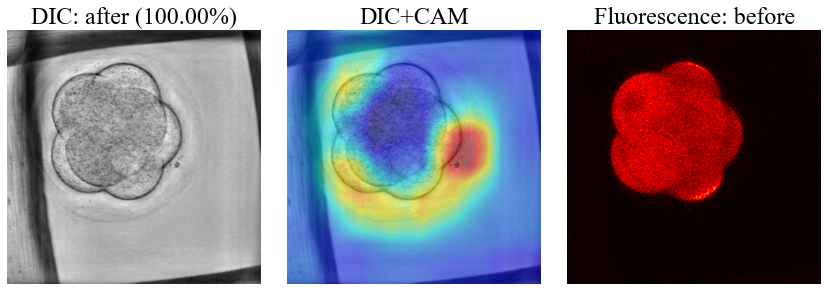

In [77]:
FN_idx = 12
group_id = np.floor(itemindex[0][FN_idx]/batch_size)
for i, batch in enumerate(test_data):
    if i == group_id:
      data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
      label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
      break
for i, batch in enumerate(fluo_test_data):
    if i == group_id:
      fluo_data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
      break
test_idx = np.remainder(itemindex[0][FN_idx], batch_size)
test_image = data[0][test_idx].expand_dims(0)
test_label = label[0][test_idx].asnumpy()
test_image_fluo = fluo_data[0][test_idx].expand_dims(0)

classes = ['before','after']

test_CAM_list = []
outputs = []
for idx, finetune_net in enumerate(ResNet_list):
  output = finetune_net(test_image)
  pred_idx = mx.nd.argmax(output).asscalar().astype('int32')
  if idx == 0:
    outputs = output
  else:
    outputs = outputs+output

  params_list = list(finetune_net.collect_params())
  weight_softmax = finetune_net.collect_params()[params_list[-2]].data().asnumpy()
  features_blob = finetune_net.features[:-4](test_image).asnumpy()

  CAMs = returnCAM(features_blob, weight_softmax, pred_idx)
  _ , _ , height, width = test_image.shape
  test_CAM = resize(CAMs, (512, 512))
  test_CAM_list.append(test_CAM)

test_CAM_avg = np.mean(np.asarray(test_CAM_list),axis=0)
a = mx.ndarray.softmax(outputs).asnumpy()
ensemble_pred_idx = np.argmax(a,axis=1).astype('int32')
max_pred_prob = np.max(a)

# convert <NDArray 1x3x512x512 @gpu(0)> to <NumArray 512x512x3 @memory>
test_image_narray = np.squeeze(test_image.asnumpy())[0,:,:]*X_std+X_mean
test_image_squeeze = (NormalizeData(test_image_narray)*255).astype(np.uint8)
test_image_narray_fluo = np.squeeze(test_image_fluo.asnumpy())[0,:,:]*X_std+X_mean
test_image_squeeze_fluo = (NormalizeData(test_image_narray_fluo)*255).astype(np.uint8)

heatmap = cv2.applyColorMap(255-np.uint8(255 * NormalizeData(test_CAM_avg)), cv2.COLORMAP_JET)
overlay = heatmap * 0.5 + np.repeat(test_image_squeeze[:,:,np.newaxis],3,axis=2) * 0.5

images = []
images.append(test_image_squeeze)
images.append(overlay.astype('uint8'))
images.append(test_image_squeeze_fluo)

titles = ['DIC: '+classes[int(ensemble_pred_idx)]+(' (%.2f%%)' % (100*max_pred_prob)),'DIC+CAM','Fluorescence: '+classes[int(test_label)]]
cmaps = ['gray',None,'hot'] # gist_heat
fig = show_images(images, titles, cmaps)

In [ ]:
former_group_id = np.floor(itemindex[0][0]/batch_size)
for i, batch in enumerate(test_data):
    if i == former_group_id:
      data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
      label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
      break
for i, batch in enumerate(fluo_test_data):
    if i == former_group_id:
      fluo_data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
      break

for failure_idx in range(len(itemindex[0])):
  group_id = np.floor(itemindex[0][failure_idx]/batch_size)
  if group_id != former_group_id:
    for i, batch in enumerate(test_data):
        if i == group_id:
          data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
          label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
          break
    for i, batch in enumerate(fluo_test_data):
        if i == group_id:
          fluo_data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
          break
    former_group_id = group_id
  
  test_idx = np.remainder(itemindex[0][failure_idx], batch_size)
  test_image = data[0][test_idx].expand_dims(0)
  test_label = label[0][test_idx].asnumpy()
  test_image_fluo = fluo_data[0][test_idx].expand_dims(0)

  test_CAM_list = []
  outputs = []
  for idx, finetune_net in enumerate(ResNet_list):
    output = finetune_net(test_image)
    pred_idx = mx.nd.argmax(output).asscalar().astype('int32')
    if idx == 0:
      outputs = output
    else:
      outputs = outputs+output

    params_list = list(finetune_net.collect_params())
    weight_softmax = finetune_net.collect_params()[params_list[-2]].data().asnumpy()
    features_blob = finetune_net.features[:-4](test_image).asnumpy()

    CAMs = returnCAM(features_blob, weight_softmax, pred_idx)
    _ , _ , height, width = test_image.shape
    test_CAM = resize(CAMs, (512, 512))
    test_CAM_list.append(test_CAM)

  test_CAM_avg = np.mean(np.asarray(test_CAM_list),axis=0)
  a = mx.ndarray.softmax(outputs).asnumpy()
  ensemble_pred_idx = np.argmax(a,axis=1).astype('int32')
  max_pred_prob = np.max(a)

  # convert <NDArray 1x3x512x512 @gpu(0)> to <NumArray 512x512x3 @memory>
  test_image_narray = np.squeeze(test_image.asnumpy())[0,:,:]*X_std+X_mean
  test_image_squeeze = (NormalizeData(test_image_narray)*255).astype(np.uint8)
  test_image_narray_fluo = np.squeeze(test_image_fluo.asnumpy())[0,:,:]*X_std+X_mean
  test_image_squeeze_fluo = (NormalizeData(test_image_narray_fluo)*255).astype(np.uint8)

  heatmap = cv2.applyColorMap(255-np.uint8(255 * NormalizeData(test_CAM_avg)), cv2.COLORMAP_JET)
  overlay = heatmap * 0.5 + np.repeat(test_image_squeeze[:,:,np.newaxis],3,axis=2) * 0.5

  images = []
  images.append(test_image_squeeze)
  images.append(overlay.astype('uint8'))
  images.append(test_image_squeeze_fluo)

  titles = ['DIC: '+classes[int(ensemble_pred_idx)]+(' (%.2f%%)' % (100*max_pred_prob)),'DIC+CAM','Fluorescence: '+classes[int(test_label)]]
  cmaps = ['gray',None,'hot']
  fig = show_images(images, titles, cmaps)

### CAM for success cases

In [ ]:
tp = record_pred==record_label
itemindex = np.where(tp==True)

# generate attention map of all successfully predicted testing DIC images 
former_group_id = np.floor(itemindex[0][0]/batch_size)
for i, batch in enumerate(test_data):
    if i == former_group_id:
      data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
      label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
      break
for i, batch in enumerate(fluo_test_data):
    if i == former_group_id:
      fluo_data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
      break

for success_idx in range(len(itemindex[0])):
  group_id = np.floor(itemindex[0][success_idx]/batch_size)
  if group_id != former_group_id:
    for i, batch in enumerate(test_data):
        if i == group_id:
          data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
          label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
          break
    for i, batch in enumerate(fluo_test_data):
        if i == group_id:
          fluo_data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
          break
    former_group_id = group_id
  
  test_idx = np.remainder(itemindex[0][success_idx], batch_size)
  test_image = data[0][test_idx].expand_dims(0)
  test_label = label[0][test_idx].asnumpy()
  test_image_fluo = fluo_data[0][test_idx].expand_dims(0)

  test_CAM_list = []
  outputs = []
  for idx, finetune_net in enumerate(ResNet_list):
    output = finetune_net(test_image)
    pred_idx = mx.nd.argmax(output).asscalar().astype('int32')
    if idx == 0:
      outputs = output
    else:
      outputs = outputs+output

    params_list = list(finetune_net.collect_params())
    weight_softmax = finetune_net.collect_params()[params_list[-2]].data().asnumpy()
    features_blob = finetune_net.features[:-4](test_image).asnumpy()

    CAMs = returnCAM(features_blob, weight_softmax, pred_idx)
    _ , _ , height, width = test_image.shape
    test_CAM = resize(CAMs, (512, 512))
    test_CAM_list.append(test_CAM)

  test_CAM_avg = np.mean(np.asarray(test_CAM_list),axis=0)
  a = mx.ndarray.softmax(outputs).asnumpy()
  ensemble_pred_idx = np.argmax(a,axis=1).astype('int32')
  max_pred_prob = np.max(a)

  # convert <NDArray 1x3x512x512 @gpu(0)> to <NumArray 512x512x3 @memory>
  test_image_narray = np.squeeze(test_image.asnumpy())[0,:,:]*X_std+X_mean
  test_image_squeeze = (NormalizeData(test_image_narray)*255).astype(np.uint8)
  test_image_narray_fluo = np.squeeze(test_image_fluo.asnumpy())[0,:,:]*X_std+X_mean
  test_image_squeeze_fluo = (NormalizeData(test_image_narray_fluo)*255).astype(np.uint8)

  heatmap = cv2.applyColorMap(255-np.uint8(255 * NormalizeData(test_CAM_avg)), cv2.COLORMAP_JET)
  overlay = heatmap * 0.5 + np.repeat(test_image_squeeze[:,:,np.newaxis],3,axis=2) * 0.5

  images = []
  images.append(test_image_squeeze)
  images.append(overlay.astype('uint8'))
  images.append(test_image_squeeze_fluo)

  titles = ['DIC: '+classes[int(ensemble_pred_idx)]+(' (%.2f%%)' % (100*max_pred_prob)),'DIC+CAM','Fluorescence: '+classes[int(test_label)]]
  cmaps = ['gray',None,'hot']
  fig = show_images(images, titles, cmaps)